# DDPM From scratch in PyTorch

Denoise Diffusion Probabilistic Models (DDPMs) are generative models based on the idea of reversing a noising process.

# Author


<img src="https://www.brianpulfer.ch/static/media/MeBig.9a9d3458.jpg" alt="Picture of Brian Pulfer" width="400"/> <br/>
**Brian Pulfer** <br/>
[🌐 Website](https://www.brianpulfer.ch) [🐦 Twitter](https://twitter.com/PulferBrian21), [🧑🏽‍💻 GitHub](https://github.com/BrianPulfer), [👔 LinekdIn](https://www.linkedin.com/in/BrianPulfer/)<br/>
University of Geneva <br/>
Stochastic Information Processing Group <br/>
<br/>
Last modified: <i>05.07.2022</i>

# Acknowledgements

This notebook was possible thanks also to these amazing people that helped me grasp the math and implementation of DDPMs:

 - <b>Lilian Weng</b>'s [blog](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/): <i>What are Diffusion Models?</i>
 - <b>abarankab</b>'s [Github repository](https://github.com/abarankab/DDPM)
 - <b>Jascha Sohl-Dickstein</b>'s [MIT class](https://www.youtube.com/watch?v=XCUlnHP1TNM&ab_channel=AliJahanian)
 - <b>Niels Rogge</b> and <b>Kashif Rasul</b> [Huggingface's blog](https://huggingface.co/blog/annotated-diffusion): <i>The Annotated Diffusion Model</i>
 - <b>Outlier</b>'s [Youtube video](https://www.youtube.com/watch?v=HoKDTa5jHvg&ab_channel=Outlier)

## Installs

In [ ]:
# !pip install --upgrade pip --quiet
# No installs...

### Imports

In [ ]:
import random

%matplotlib inline
import numpy as np

from tqdm.auto import tqdm

import matplotlib.pyplot as plt
%pylab inline

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.nn.functional import one_hot

from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST

# Setting reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Loading data
We will use the MNIST dataset and try to generate some new samples out of random gaussian noise. We normalize images in range [-1,1]

In [ ]:
transform = Compose([ToTensor(), Lambda(lambda x: (x-0.5) * 2)]) # Convert each image into a tensor, and normalize between [-1, 1]
dataset = MNIST("./", download=True, train=True, transform=transform) # (Downloading and) Loading MNIST's train-set
loader = DataLoader(dataset, 64, shuffle=True)

### Utility function to show images

In [ ]:
def show_images(images, title=""):
  """Shows the provided images as sub-pictures in a square"""

  # Converting images to CPU numpy arrays
  if type(images) is torch.Tensor:
      images = images.detach().cpu().numpy()

  # Defining number of rows and columns
  fig = plt.figure(figsize=(8, 8))
  rows = int(len(images)**(1/2))
  cols = round(len(images) / rows)
  
  # Populating figure with sub-plots
  idx = 0
  for r in range(rows):
    for c in range(cols):
      fig.add_subplot(rows, cols, idx+1)

      if idx < len(images):
        plt.imshow(images[idx][0], cmap="gray")
        idx += 1
  fig.suptitle(title, fontsize=30)

  # Showing the figure
  plt.show()

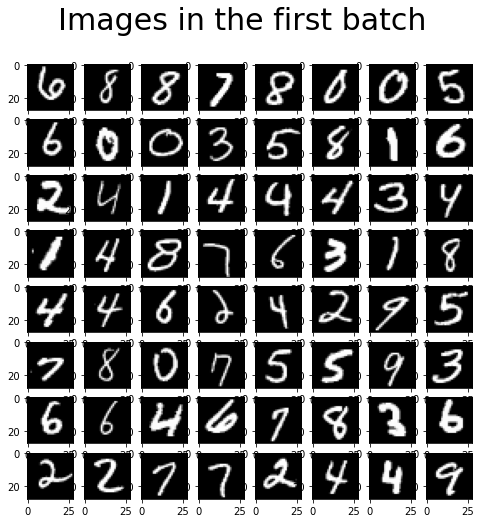

In [ ]:
# Show the images that compose the first batch of our dataset
for batch in loader:
  show_images(batch[0], "Images in the first batch")
  break

## The model

To implement a DDPM model, we need to define some parameters:
 - Number of noising steps
 - Beta used for each noising step
 - Network architecture to be used for the reverse process (at each step)

Given these informations, we can implement a class that implements the forward and backward pass. Notice that through the re-parametrization trick, we don't need to run each noising step one-by-one, but we can skip directly to whatever step we want.

Notice that this class is compatible with no matter what type of network architecture, as long as the input and output dimensions are the same as the data (Nx1x28x28 for MNIST images).

In [ ]:
class MyDDPM(nn.Module):
    def __init__(self, network, n_steps=200, min_beta=10**-4, max_beta=0.02, device=None, image_chw=(1,28,28)):
        super(MyDDPM, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.image_chw = image_chw
        self.network = network.to(device)
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(device)  # Number of steps is typically in the order of thousands
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i+1]) for i in range(len(self.alphas))]).to(device)

    def forward(self, x0, t, eta=None):
        # Make input image more noisy (we can directly skip to the desired step)
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]

        if eta is None:
            eta = torch.randn(n, c, h, w).to(self.device)

        noisy = a_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta
        return noisy

    def backward(self, x, t):
        # Run each image through the network for each timestep t in the vector t.
        # The network returns its estimation of the noise that was added.
        return self.network(x, t)

## Denoising model

Now that we have a class that acts as the DDPM, we just need to decide which network will actually do the job of denoising the image with each step. We will use a U-Net like architecture.


In [ ]:
class MyBlock(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(MyBlock, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out
        

class MyUNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100):
        super(MyUNet, self).__init__()

        self.time_embed = nn.Embedding(n_steps, time_emb_dim)

        # First half
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = nn.Sequential(
            MyBlock((1, 28, 28), 1, 10),
            MyBlock((10, 28, 28), 10, 10),
            MyBlock((10, 28, 28), 10, 10)
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = nn.Sequential(
            MyBlock((10, 14, 14), 10, 20),
            MyBlock((20, 14, 14), 20, 20),
            MyBlock((20, 14, 14), 20, 20)
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)


        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = nn.Sequential(
            MyBlock((20, 7, 7), 20, 40),
            MyBlock((40, 7, 7), 40, 40),
            MyBlock((40, 7, 7), 40, 40)
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1),
            nn.SiLU(),
            nn.Conv2d(40, 40, 4, 2, 1)
        )

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            MyBlock((40, 3, 3), 40, 20),
            MyBlock((20, 3, 3), 20, 20),
            MyBlock((20, 3, 3), 20, 40)
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1)
        )

        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = nn.Sequential(
            MyBlock((80, 7, 7), 80, 40),
            MyBlock((40, 7, 7), 40, 20),
            MyBlock((20, 7, 7), 20, 20)
        )

        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = nn.Sequential(
            MyBlock((40, 14, 14), 40, 20),
            MyBlock((20, 14, 14), 20, 10),
            MyBlock((10, 14, 14), 10, 10)
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = nn.Sequential(
            MyBlock((20, 28, 28), 20, 10),
            MyBlock((10, 28, 28), 10, 10),
            MyBlock((10, 28, 28), 10, 10, normalize=False)
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

    def forward(self, x, t):
        # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension)
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1)) # (N, 10, 28, 28)
        out2 = self.b2(self.down1(out1) )#+ self.te2(t).reshape(n, -1, 1, 1)) # (N, 20, 14, 14)
        out3 = self.b3(self.down2(out2) )#+ self.te3(t).reshape(n, -1, 1, 1)) # (N, 40, 7, 7)

        out_mid = self.b_mid(self.down3(out3) )#+ self.te_mid(t).reshape(n, -1, 1, 1)) # (N, 40, 3, 3)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1) # (N, 80, 7, 7)
        out4 = self.b4(out4 )#+ self.te4(t).reshape(n, -1, 1, 1)) # (N, 20, 7, 7)

        out5 = torch.cat((out2, self.up2(out4)), dim=1) # (N, 40, 14, 14)
        out5 = self.b5(out5 )#+ self.te5(t).reshape(n, -1, 1, 1)) # (N, 10, 14, 14)

        out = torch.cat((out1, self.up3(out5)), dim=1) # (N, 20, 28, 28)
        out = self.b_out(out )#+ self.te_out(t).reshape(n, -1, 1, 1)) # (N, 1, 28, 28)

        out = self.conv_out(out)

        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

In [ ]:
# Getting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\t" + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))

# Defining model
n_steps, min_beta, max_beta = 1000, 10**-4, 0.02    # Originally used by the authors
ddpm = MyDDPM(MyUNet(n_steps), n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)

Using device: cuda	Tesla T4


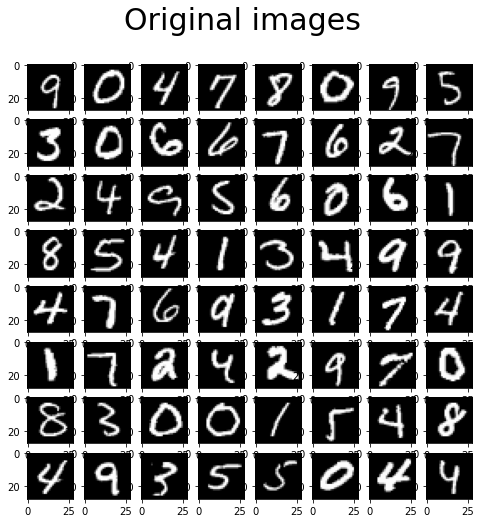

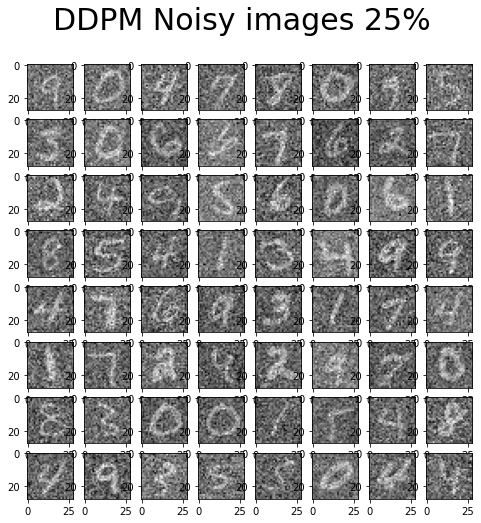

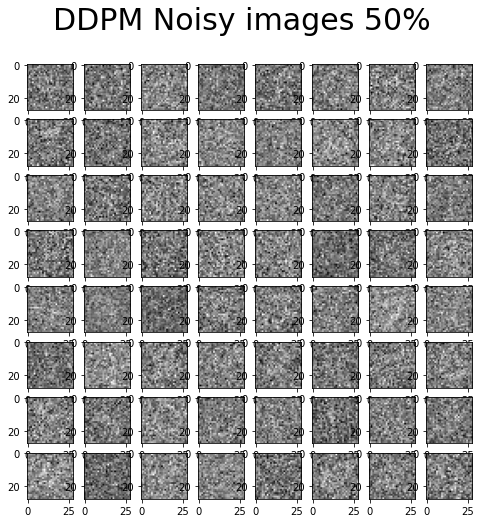

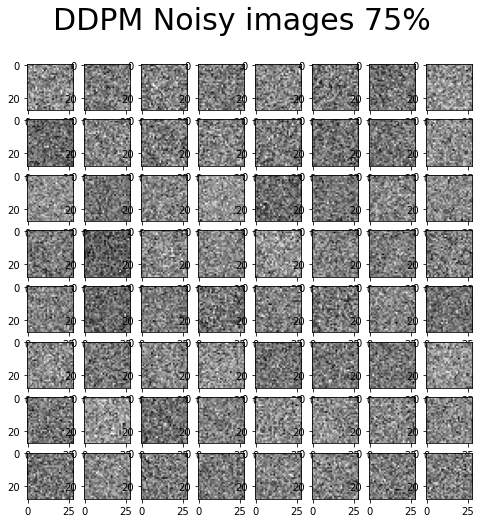

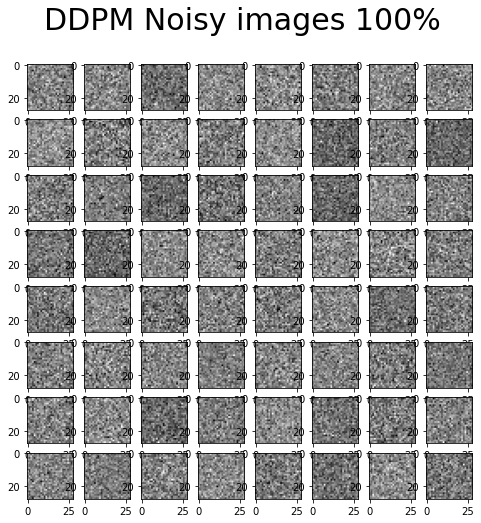

In [ ]:
# Showing the forward process
for batch in loader:
    imgs = batch[0]

    show_images(imgs, "Original images")

    for percent in [0.25, 0.5, 0.75, 1]:
        show_images(
            ddpm(imgs.to(device),
            [int(percent * ddpm.n_steps)-1 for _ in range(len(imgs))]),
            f"DDPM Noisy images {int(percent*100)}%"
        )
    break

Notice that in this small-example, we are only using 200 steps and 
$\beta_{max} = 0.037$ (which seems to yield gaussian noise images for t=200), whereas in the original DDPM paper, 1'000 steps with $\beta_{max} = 0.02$ were used. 

In other words, our toy example adds much more noise with each step, since we only want to run 200 of them. In principle, more steps with less noise added per step results in better generators, but comes with a higher computational cost.

In [ ]:
def generate_new_images(ddpm, n_samples = 16, device=None, stochastic=True, show_each=None):
    """Given a DDPM model, a number of samples to be generated and a device, returns some newly generated samples"""
    with torch.no_grad():
        if device is None:
            device = ddpm.device

        x = torch.randn(n_samples, 1, 28, 28).to(device)
        
        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            eta_theta = ddpm.backward(x, time_tensor)

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]
            beta_t = ddpm.betas[t]
            z = torch.randn(n_samples, 1, 28, 28).to(device) if t > 0 and not stochastic else 0
            
            x = 1/alpha_t.sqrt() * (x - (1-alpha_t)/(1-alpha_t_bar).sqrt() * eta_theta) + beta_t.sqrt() * z
            # x = 1/alpha_t.sqrt() * (x - (1-alpha_t)/(1-alpha_t_bar).sqrt() * eta_theta) + beta_t * z
            
            if show_each is not None:
                if idx % show_each == 0:
                    show_images(x, f"Step {t+1}")
    return x

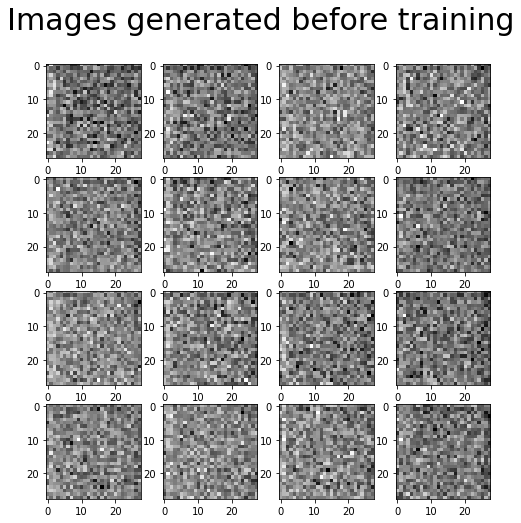

In [ ]:
generated = generate_new_images(ddpm)
show_images(generated,"Images generated before training")

## Training
We train a DDPM model by, for each batch in each epoch, picking random time-steps and optimizing the models responsible for those time-steps to predict the noise that was added to the images at that time-step.

In [ ]:
n_epochs = 20
lr = 0.001
optimizer_fn = Adam
display = False # Whether to display images as training progresses

In [ ]:
optim = optimizer_fn(ddpm.parameters(), lr)
best_loss = float("inf")

In [ ]:
mse = nn.MSELoss()
ddpm.train()

for epoch in tqdm(range(n_epochs), desc=f"Training progress", colour="#00ff00"):
    epoch_loss = 0.0
    for step, batch in enumerate(tqdm(loader, leave=False, desc=f"Epoch {epoch+1}/{n_epochs}", colour="#005500")):
        # Loading data
        x0 = batch[0].to(device)
        n = len(x0)

        # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
        eta = torch.randn(n, 1, 28, 28).to(device)
        t = torch.randint(0, n_steps, (n,)).to(device)

        # Computing the noisy image based on x0 and the time-step (forward process)
        noisy_imgs = ddpm(x0, t, eta)

        # Getting model estimation of noise based on the images and the time-step
        eta_theta = ddpm.backward(noisy_imgs, t.reshape(n, -1))

        # Optimizing the MSE between the noise plugged and the predicted noise
        loss = mse(eta_theta, eta)
        optim.zero_grad()
        loss.backward()
        optim.step()

        epoch_loss += loss.item() * len(x0) / len(loader.dataset)

    # Display images generated at this epoch
    if display:
        show_images(generate_new_images(ddpm, device=device), f"Images generated at epoch {epoch+1}")
    
    log_string = f"Loss at epoch {epoch+1}: {epoch_loss:.3f}"

    # Storing the model
    if best_loss > epoch_loss:
        best_loss = epoch_loss
        torch.save(ddpm.state_dict(), f"ddpm_model.pt")
        log_string += " --> Best model ever (stored)"
    
    print(log_string)

Training progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/938 [00:00<?, ?it/s]

## Testing

In [ ]:
best_model = MyDDPM(MyUNet(), n_steps=n_steps, device=device)
best_model.load_state_dict(torch.load("ddpm_model.pt", map_location=device))
#best_model.eval()
print("Model loaded")

Model loaded


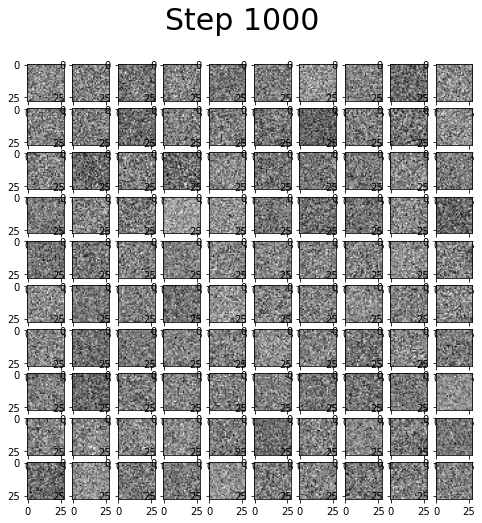

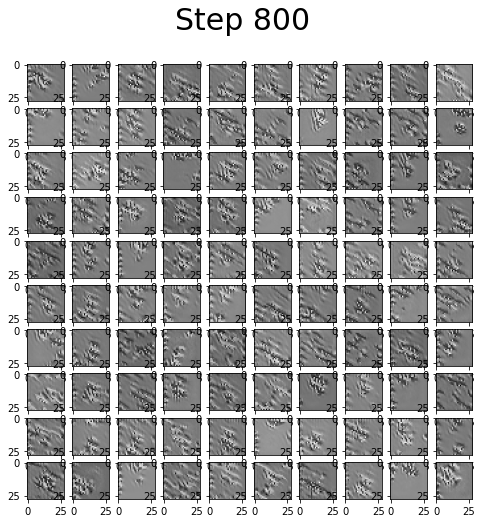

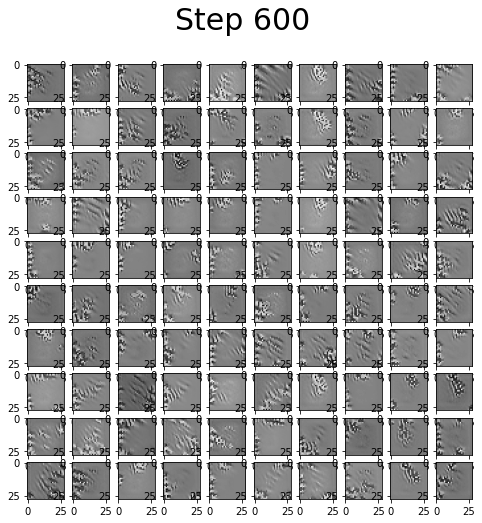

KeyboardInterrupt: ignored

In [ ]:
generated = generate_new_images(best_model, n_samples = 100, device=device, show_each=n_steps//5, stochastic=True)
show_images(generated, "Final result")

# Conclusion
With this brief notebook, we have touched upon what DDPMs are, how they work and how we can train one from scratch using PyTorch.

Notice that the notebook